# Arsenal Social Sentiment Analysis
## Forecasting User Sentiment between games. 
by *Ben N. Bellman* 
<br> Prepared as Springboard Capstone Project
<br> *4/13/2022*

<img src="../images/who-s-denilo-SuBb_SiEEM8-unsplash.jpg" style="width:800px;height:400px"/>

### WARNING: 
*Although the usernames have been anonymized as to protect the privacy of the users in this analysis, the tweets are still in raw format and may contain inappropriate / sensitive content. Viewer discretion is advised*

## Outline

## Data Mapping: 

One of the important things to know for the analysis is the schedule of the games.
The objective in the social sentiment analysis is to predict whether or not a specific tweet is likely to come  

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from wordcloud import WordCloud
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


import re

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss,matthews_corrcoef, ConfusionMatrixDisplay

from io import StringIO 
from IPython.display import Image,HTML 
import shap

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',-1)
%matplotlib inline

In [2]:
## Import Functions from pandas module.
import sys
sys.path.insert(1, './../../Analysis_Functions_For_Pandas')
from functions import (preview_data,
                       get_missing_counts,
                       get_value_counts,
                       get_unique_column_count,
                       get_datetimes)   

In [3]:
## Load the Data
df = pd.read_csv('.\..\Data\Finalized_DataFrame_All_Data_2_Anonymized.csv')

## I. Data Exploration

We use Twitter Scraper to collect the tweets. There will be a total of **370,000** tweets. 

In [4]:
## Start by previewing the data:
preview_data(df)

First Five Rows of Data: 



,Query2,Date,Username,Tweet,TweetLikes,TweetReplies,RetweetCount,Result,Team
0,Arsenal until:2022-04-24,2022-04-23 23:59:47+00:00,Anonymous19203,@JackAFC01 @LUHG450 @1Thegameis Because you're arsenal and you have no self awareness..in our worst season in years and your best season in years and you only 6 points ahead of us and you think the gap is that big lol 🤣be real now,1,1,0,1,Arsenal
1,Arsenal until:2022-04-24,2022-04-23 23:59:41+00:00,Anonymous123302,@arsenal_lady bei ihm werde ich einfach immer schwach,1,0,0,1,Arsenal
2,Arsenal until:2022-04-24,2022-04-23 23:59:39+00:00,Anonymous134105,"5 games to go\n\n5 cup finals \n\n5 games to UCL or UEL, either way I want my European trips back.\n\nWe can do it @Arsenal",0,0,0,1,Arsenal
3,Arsenal until:2022-04-24,2022-04-23 23:59:37+00:00,Anonymous112922,"@Arsenal @HectorBellerin VAMOS @HectorBellerin ! Even if you stay in Spain, you'll always be loved in North London ;-)",18,0,0,1,Arsenal
4,Arsenal until:2022-04-24,2022-04-23 23:59:32+00:00,Anonymous65885,@Cristiano Come to @Arsenal 🐐.. so many assists and crosses with no one to finish/ tap in.,0,0,0,1,Arsenal



 Shape: 

(370000, 9)

 Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370000 entries, 0 to 369999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Query2        370000 non-null  object
 1   Date          370000 non-null  object
 2   Username      370000 non-null  object
 3   Tweet         370000 non-null  object
 4   TweetLikes    370000 non-null  int64 
 5   TweetReplies  370000 non-null  int64 
 6   RetweetCount  370000 non-null  int64 
 7   Result        370000 non-null  int64 
 8   Team          370000 non-null  object
dtypes: int64(4), object(5)
memory usage: 25.4+ MB
None


In [5]:
## Get the missing values
get_missing_counts(df)

Missing Value Percentages by Column: 

Query2 -----> 0 -----> 0.0%
Date -----> 0 -----> 0.0%
Username -----> 0 -----> 0.0%
Tweet -----> 0 -----> 0.0%
TweetLikes -----> 0 -----> 0.0%
TweetReplies -----> 0 -----> 0.0%
RetweetCount -----> 0 -----> 0.0%
Result -----> 0 -----> 0.0%
Team -----> 0 -----> 0.0%


In [6]:
## Get unique values in each column: 
get_unique_column_count(df)

Unique values in each object column: 

Query2: 370
Date: 317152
Username: 200163
Tweet: 364939
Team: 2


## II. Data Wrangling

In [7]:
## Remove Usernames
def remove_usernames_links(tweet):
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub('http[^\s]+','',tweet)
    return tweet
df['CleanTweet'] = df['Tweet'].apply(remove_usernames_links)
## Preview
df.head(3)

,Query2,Date,Username,Tweet,TweetLikes,TweetReplies,RetweetCount,Result,Team,CleanTweet
0,Arsenal until:2022-04-24,2022-04-23 23:59:47+00:00,Anonymous19203,@JackAFC01 @LUHG450 @1Thegameis Because you're arsenal and you have no self awareness..in our worst season in years and your best season in years and you only 6 points ahead of us and you think the gap is that big lol 🤣be real now,1,1,0,1,Arsenal,Because you're arsenal and you have no self awareness..in our worst season in years and your best season in years and you only 6 points ahead of us and you think the gap is that big lol 🤣be real now
1,Arsenal until:2022-04-24,2022-04-23 23:59:41+00:00,Anonymous123302,@arsenal_lady bei ihm werde ich einfach immer schwach,1,0,0,1,Arsenal,bei ihm werde ich einfach immer schwach
2,Arsenal until:2022-04-24,2022-04-23 23:59:39+00:00,Anonymous134105,"5 games to go\n\n5 cup finals \n\n5 games to UCL or UEL, either way I want my European trips back.\n\nWe can do it @Arsenal",0,0,0,1,Arsenal,"5 games to go\n\n5 cup finals \n\n5 games to UCL or UEL, either way I want my European trips back.\n\nWe can do it"


In [8]:
## Replace Punctuation
df['CleanTweet'] = df['CleanTweet'].str.replace("[^a-zA-Z#]"," ")
df.head(3)

,Query2,Date,Username,Tweet,TweetLikes,TweetReplies,RetweetCount,Result,Team,CleanTweet
0,Arsenal until:2022-04-24,2022-04-23 23:59:47+00:00,Anonymous19203,@JackAFC01 @LUHG450 @1Thegameis Because you're arsenal and you have no self awareness..in our worst season in years and your best season in years and you only 6 points ahead of us and you think the gap is that big lol 🤣be real now,1,1,0,1,Arsenal,Because you re arsenal and you have no self awareness in our worst season in years and your best season in years and you only points ahead of us and you think the gap is that big lol be real now
1,Arsenal until:2022-04-24,2022-04-23 23:59:41+00:00,Anonymous123302,@arsenal_lady bei ihm werde ich einfach immer schwach,1,0,0,1,Arsenal,bei ihm werde ich einfach immer schwach
2,Arsenal until:2022-04-24,2022-04-23 23:59:39+00:00,Anonymous134105,"5 games to go\n\n5 cup finals \n\n5 games to UCL or UEL, either way I want my European trips back.\n\nWe can do it @Arsenal",0,0,0,1,Arsenal,games to go cup finals games to UCL or UEL either way I want my European trips back We can do it


In [9]:
## Create Simplified DataFrame
simp = df[['Username','Result','CleanTweet','Query2','Team']]
simp.head()

,Username,Result,CleanTweet,Query2,Team
0,Anonymous19203,1,Because you re arsenal and you have no self awareness in our worst season in years and your best season in years and you only points ahead of us and you think the gap is that big lol be real now,Arsenal until:2022-04-24,Arsenal
1,Anonymous123302,1,bei ihm werde ich einfach immer schwach,Arsenal until:2022-04-24,Arsenal
2,Anonymous134105,1,games to go cup finals games to UCL or UEL either way I want my European trips back We can do it,Arsenal until:2022-04-24,Arsenal
3,Anonymous112922,1,VAMOS Even if you stay in Spain you ll always be loved in North London,Arsenal until:2022-04-24,Arsenal
4,Anonymous65885,1,Come to so many assists and crosses with no one to finish tap in,Arsenal until:2022-04-24,Arsenal


In [10]:
## Replace 1 with Win and 0 with Loss/Tie
simp.loc[:,"Result"] = simp.Result.replace(1,'Win').replace(0,'Loss/Tie')
simp.head()

,Username,Result,CleanTweet,Query2,Team
0,Anonymous19203,Win,Because you re arsenal and you have no self awareness in our worst season in years and your best season in years and you only points ahead of us and you think the gap is that big lol be real now,Arsenal until:2022-04-24,Arsenal
1,Anonymous123302,Win,bei ihm werde ich einfach immer schwach,Arsenal until:2022-04-24,Arsenal
2,Anonymous134105,Win,games to go cup finals games to UCL or UEL either way I want my European trips back We can do it,Arsenal until:2022-04-24,Arsenal
3,Anonymous112922,Win,VAMOS Even if you stay in Spain you ll always be loved in North London,Arsenal until:2022-04-24,Arsenal
4,Anonymous65885,Win,Come to so many assists and crosses with no one to finish tap in,Arsenal until:2022-04-24,Arsenal


In [11]:
## Tokenize the Tweet

## Split the words
tokenized_tweet = simp['CleanTweet'].apply(lambda x: x.split())

## Initiate Lemmatizer and apply it to the words
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

## Create new LemmatizedTweet Columns
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
simp['LemmatizedTweet'] = tokenized_tweet
simp.head()

,Username,Result,CleanTweet,Query2,Team,LemmatizedTweet
0,Anonymous19203,Win,Because you re arsenal and you have no self awareness in our worst season in years and your best season in years and you only points ahead of us and you think the gap is that big lol be real now,Arsenal until:2022-04-24,Arsenal,Because you re arsenal and you have no self awareness in our worst season in year and your best season in year and you only point ahead of u and you think the gap is that big lol be real now
1,Anonymous123302,Win,bei ihm werde ich einfach immer schwach,Arsenal until:2022-04-24,Arsenal,bei ihm werde ich einfach immer schwach
2,Anonymous134105,Win,games to go cup finals games to UCL or UEL either way I want my European trips back We can do it,Arsenal until:2022-04-24,Arsenal,game to go cup final game to UCL or UEL either way I want my European trip back We can do it
3,Anonymous112922,Win,VAMOS Even if you stay in Spain you ll always be loved in North London,Arsenal until:2022-04-24,Arsenal,VAMOS Even if you stay in Spain you ll always be loved in North London
4,Anonymous65885,Win,Come to so many assists and crosses with no one to finish tap in,Arsenal until:2022-04-24,Arsenal,Come to so many assist and cross with no one to finish tap in


In [12]:
## Get info 
n_tweets = len(simp)
n_users = simp.Username.unique().size
n_games = simp.Query2.unique().size

print("Number of tweets: {:d}".format(n_tweets))
print("Number of users: {:d}".format(n_users))
print("Number of games: {:d}".format(n_games))

Number of tweets: 370000
Number of users: 200163
Number of games: 370


In [13]:
## We Create X and y
def make_xy(simp, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(simp.LemmatizedTweet)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (simp.Result == 'Win').values.astype(np.int)
    #print(vectorizer.get_feature_names())
    return X, y
X, y = make_xy(simp)

In [14]:
## Train Test-Split
xtrain, xtest, ytrain, ytest = train_test_split(X,y)
clf = MultinomialNB().fit(xtrain, ytrain)
train_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print('Multinomial Naive Bayes')
print('Accuracy on the test set: {}'.format(test_accuracy))
print('Accuracy on the training set: {}'.format(train_accuracy))

Multinomial Naive Bayes
Accuracy on the test set: 0.6232864864864864
Accuracy on the training set: 0.6930198198198199


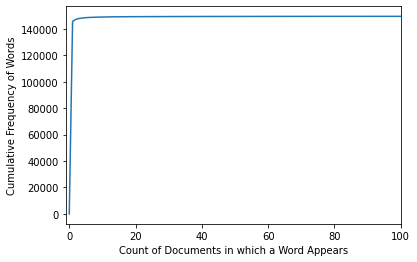

In [15]:
# For each word, count the number of documents that contains it 
count = (X>0).sum(axis=0).tolist()[0]
count = sorted(count)
n = np.unique(count)

# Compute the frequency of words that appear in exactly k documents
freq, cat = np.histogram(count, bins = len(n))
cumfreq = np.cumsum(freq)
cumfreq = np.insert(cumfreq,0,0)
n = np.insert(n,0,0)

plt.plot(n,cumfreq)
plt.xlim(-1,100)
plt.xlabel('Count of Documents in which a Word Appears')
plt.ylabel('Cumulative Frequency of Words')
plt.show()

## Preprocessing

In [16]:
## Train Text Split
itrain, itest = train_test_split(range(simp.shape[0]), train_size=0.7)
mask = np.zeros(simp.shape[0], dtype=np.bool)
mask[itest] = True

In [17]:
## Vectorizer is CountVectorizer, min_df = 20 
vectorizer = CountVectorizer(min_df=100, stop_words='english')
X, y = make_xy(simp, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=0.5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.626661
Accuracy on test data:     0.605693


In [18]:
## Vectorizer is CountVectorizer, min_df = 20 
vectorizer = CountVectorizer(min_df=20, stop_words='english')
X, y = make_xy(simp, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = LogisticRegression().fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.693489
Accuracy on test data:     0.615053


In [27]:
## Vectorizer is TfidVectorizer
vectorizer = TfidfVectorizer(min_df=200, stop_words='english')
X, y = make_xy(simp, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = LogisticRegression().fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.634598
Accuracy on test data:     0.608500


In [20]:
## Default Metrics: 
print('Default Accuracy is: {}{}'.format((round(len(simp[simp.Result =='Win']) / len(simp)*100,2)),'%'))
print('Default F1 Score is: {}{}'.format((round(len(simp[simp.Result =='Win']) / len(simp)*100,2)),'%'))
print('Default Recall is: {}{}'.format((round(len(simp[simp.Result =='Win']) / len(simp)*100,2)),'%'))
print('Default Precision is: {}{}'.format((round(len(simp[simp.Result =='Win']) / len(simp)*100,2)),'%'))

Default Accuracy is: 51.08%
Default F1 Score is: 51.08%
Default Recall is: 51.08%
Default Precision is: 51.08%


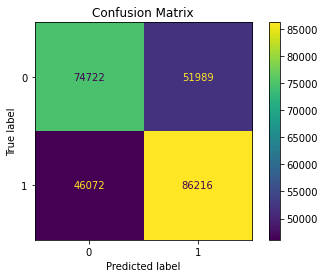

In [21]:
## 
plot_confusion_matrix(clf,xtest,ytest,values_format = '.0f')
plt.title('Confusion Matrix')
plt.show()

In [28]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:30]]
bad_words = words[ind[-30:]]

good_prob = probs[ind[:30]]
bad_prob = probs[ind[-30:]]

print("Good words\t     P(Good | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(Good | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(Good | word)
        huddersfield 0.98
              boxing 0.96
              menang 0.96
              bielsa 0.96
             cardiff 0.96
             goleada 0.95
            llorente 0.95
               magic 0.92
          kemenangan 0.92
              gareth 0.92
               besar 0.91
               heung 0.90
               mason 0.90
                coys 0.90
                gole 0.89
               aouar 0.89
               lucas 0.89
             victory 0.89
              superb 0.89
            victoire 0.88
              fulham 0.88
            victoria 0.88
              fourth 0.88
                saka 0.88
            atletico 0.87
                risk 0.86
           alexandre 0.86
               admin 0.86
               clean 0.86
                hove 0.86
Bad words	     P(Good | word)
                levy 0.19
             reality 0.19
              racism 0.19
        disappointed 0.19
                lost 0.18
             rodgers 0.18
   

In [23]:
## Exploring all the Words 
all_bad_words = " ".join([word for word in bad_words])
wordcloud = WordCloud(width =800, height = 500,
                      random_state = 42, max_font_size=100).generate(all_bad_words)

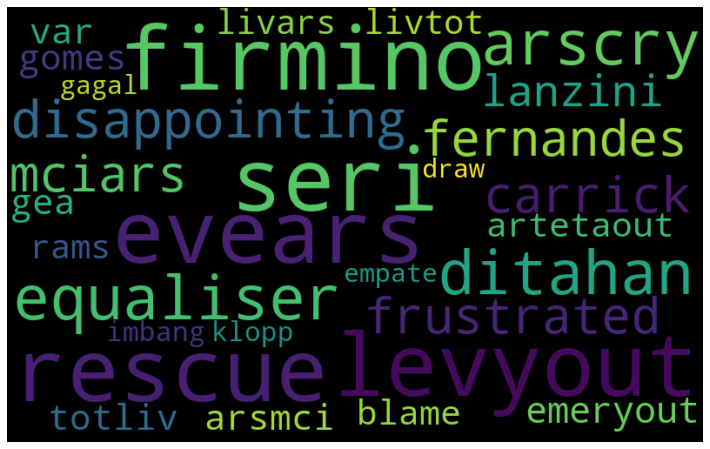

<Figure size 432x288 with 0 Axes>

In [24]:
## Creating visualizawtion  for most found words 
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation ='bilinear')
plt.axis('off')
plt.show()
plt.savefig('.\..\images\All_Tweets_Negative_Words.png')

In [25]:
## Exploring all the Words 
all_good_words = " ".join([word for word in good_words])
wordcloud = WordCloud(width =800, height = 500,
                      random_state = 42, max_font_size=100).generate(all_good_words)

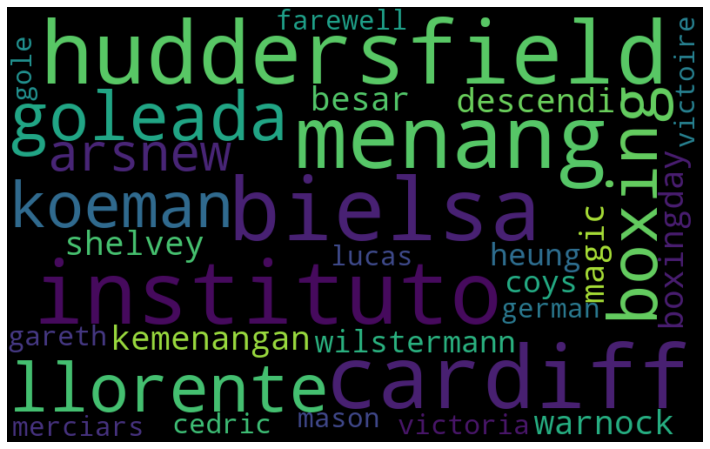

<Figure size 432x288 with 0 Axes>

In [26]:
## Creating visualizawtion  for most found words 
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation ='bilinear')
plt.axis('off')
plt.show()
plt.savefig('.\..\images\All_Tweets_Positive_Words.png')